#SparkSession

SparkSession 인스턴스는 사용자가 정의한 명령을 클러스터에서 실행을 시킨다.

하나의 SparkSession은 하나의 스파크 애플리케이션에 대응한다.
의문: 하나의 SparkSession만 존재해야 한다는 뜻인가? 아나의 애플리케이션에 하나의 세션만 필요?




In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=6e6e054dcf5e895204c8b0b1a58c0f14b185e88ffb42bce87e8101aa19cac265
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [6]:
import pyspark
import pyspark.sql as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName('myAppName').getOrCreate()

In [11]:
#한개의 컬럼과 1000개의 로우로 구성된, 0~999까지의 값이 할당.
myRange = spark.range(1000).toDF("number")

In [13]:
type(myRange)

pyspark.sql.dataframe.DataFrame

#DataFrame

DataFrame은 가장 대표적인 구조적 API

DataFrame은 컬럼에 이름을 붙인 스프레드시트와 비슷

여기서 DataFrame과 스프레드시트의 차이란
DataFrame은 여러 컴퓨터에 산재되어 있을 수 있고
스프레드시트는 하나의 컴퓨터에만 있다.

여러 컴퓨터에 데이터를 분산하는 이유는 단순하다.
단일 컴퓨터에 저장하기에 데이터가 너무 크거나 계산에 너무 오랜 시간이 필요하기 때문.

스파크가 아닌 파이썬과 R은 DataFrame이 있지만 하나의 컴퓨터에 존재.


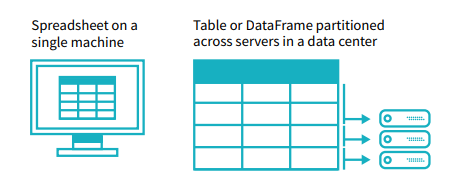

#트랜스포메이션

스파크의 핵심 데이터 구조는 **불변성**
한번 생성하면 변경이 불가능.

데이터 구조를 바꿀 수 없다? 어떻게 사용하지?

DataFrame을 변경하려면 원하는 변경법을 스파크에게 명령하는 것을
**트랜스포메이션**이라고 한다.



In [12]:
#결과가 반환되지 않음.
divisBy2 = myRange.where("number % 2=0")

위 코드는 추상적인 트랜스포메이션만 지정한 상태.
따라서 액션을 호출하지 않으면 스파크는 동작하지 않음.

이러한 트랜스포메이션이 하나의 출력 파티션만 1대1 대응을 이루면 좁은 의존성

여러 출력 파티션에 대응을 이루면 넓은 의존성(셔플).

좁은 의존성의 작업은 파이프라이닝(?)을 수행하며 메모리에서 동작.
넓은 의존성(셔플)은 결과를 디스크에 저장.






#지연 연산

스파크는 연산 명령이 떨어지면 즉시 데이터를 수정하지 않음.

원시 데이터에 적용할 트랜스포메이션의 실행 계획을 생성.

원본 DataFrame 트랜스포메이션을 간결한 물리적 실행 계획으로 컴파일함(?)

물리적 실행 계획이란 데이터베이스 관리 시스템(DBMS) 또는 빅데이터 처리 시스템에서 쿼리를 실행하는 구체적인 방법을 나타냅니다. 즉, 어떤 연산을 어떤 순서로, 어떤 알고리즘을 사용하여 수행할 것인


이 과정들은 전체 데이터 흐름을 최적화하기에 굉장히 중요하고 강점이됨.



#액션

트랜스포메이션으로부터 결과를 계산하도록 지시하는 명령.

In [14]:
#DataFrame의 레코들 수를 반환
divisBy2.count()

500

액션을 실행하면 스파크 잡이 시작.

스파크 잡은
1. 필터(좁은 트랜스포메이션)를 수행
2. 파티션별로 레코드 수를 카운트(넓은 트챈스포메이션)

#CSV Test

In [58]:
#스키마 정보를 알아내는 스키마 추론 옵션과 파일의 첫 로우를 헤더로 지정하는 옵션 사용하여 CSV를 읽음.
testData = spark.read.option("inferSchema","true").option("header","true").csv("/content/sample_data/mnist_train_small.csv")

In [16]:
#take 액션을 호출하면 이전의 head명령과 같은 결과를 확인.
testData.take(3)

[Row(6=5, 01=0, 02=0, 03=0, 04=0, 05=0, 06=0, 07=0, 08=0, 09=0, 010=0, 011=0, 012=0, 013=0, 014=0, 015=0, 016=0, 017=0, 018=0, 019=0, 020=0, 021=0, 022=0, 023=0, 024=0, 025=0, 026=0, 027=0, 028=0, 029=0, 030=0, 031=0, 032=0, 033=0, 034=0, 035=0, 036=0, 037=0, 038=0, 039=0, 040=0, 041=0, 042=0, 043=0, 044=0, 045=0, 046=0, 047=0, 048=0, 049=0, 050=0, 051=0, 052=0, 053=0, 054=0, 055=0, 056=0, 057=0, 058=0, 059=0, 060=0, 061=0, 062=0, 063=0, 064=0, 065=0, 066=0, 067=0, 068=0, 069=0, 070=0, 071=0, 072=0, 073=0, 074=0, 075=0, 076=0, 077=0, 078=0, 079=0, 080=0, 081=0, 082=0, 083=0, 084=0, 085=0, 086=0, 087=0, 088=0, 089=0, 090=0, 091=0, 092=0, 093=0, 094=0, 095=0, 096=0, 097=0, 098=0, 099=0, 0100=0, 0101=0, 0102=0, 0103=0, 0104=0, 0105=0, 0106=0, 0107=0, 0108=0, 0109=0, 0110=0, 0111=0, 0112=0, 0113=0, 0114=0, 0115=0, 0116=0, 0117=0, 0118=0, 0119=0, 0120=0, 0121=0, 0122=0, 24123=0, 67124=0, 67125=0, 18=0, 0127=0, 0128=0, 0129=0, 0130=0, 0131=0, 0132=0, 0133=0, 0134=0, 0135=0, 0136=0, 0137=0, 0

In [34]:
#sort메서드로 트랜스포메이션 실행. explain 메서드를 호출하여 계보를 확인
testData.sort("6").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [6#31 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(6#31 ASC NULLS FIRST, 5), ENSURE_REQUIREMENTS, [plan_id=125]
      +- FileScan csv [6#31,01#32,02#33,03#34,04#35,05#36,06#37,07#38,08#39,09#40,010#41,011#42,012#43,013#44,014#45,015#46,016#47,017#48,018#49,019#50,020#51,021#52,022#53,023#54,... 761 more fields] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sample_data/mnist_train_small.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<6:int,01:int,02:int,03:int,04:int,05:int,06:int,07:int,08:int,09:int,010:int,011:int,012:i...




In [30]:
#액션을 호출, 기본 200개 셔플 파티션 설정을 5로 설정
spark.conf.set("spark.sql.shuffle.partitions", "5")

testData.sort("6").take(2)

[Row(6=0, 01=0, 02=0, 03=0, 04=0, 05=0, 06=0, 07=0, 08=0, 09=0, 010=0, 011=0, 012=0, 013=0, 014=0, 015=0, 016=0, 017=0, 018=0, 019=0, 020=0, 021=0, 022=0, 023=0, 024=0, 025=0, 026=0, 027=0, 028=0, 029=0, 030=0, 031=0, 032=0, 033=0, 034=0, 035=0, 036=0, 037=0, 038=0, 039=0, 040=0, 041=0, 042=0, 043=0, 044=0, 045=0, 046=0, 047=0, 048=0, 049=0, 050=0, 051=0, 052=0, 053=0, 054=0, 055=0, 056=0, 057=0, 058=0, 059=0, 060=0, 061=0, 062=0, 063=0, 064=0, 065=0, 066=0, 067=0, 068=0, 069=0, 070=0, 071=0, 072=0, 073=0, 074=0, 075=0, 076=0, 077=0, 078=0, 079=0, 080=0, 081=0, 082=0, 083=0, 084=0, 085=0, 086=0, 087=0, 088=0, 089=0, 090=0, 091=0, 092=0, 093=0, 094=0, 095=0, 096=0, 097=0, 098=0, 099=0, 0100=0, 0101=0, 0102=0, 0103=0, 0104=0, 0105=0, 0106=0, 0107=0, 0108=0, 0109=0, 0110=0, 0111=0, 0112=0, 0113=0, 0114=0, 0115=0, 0116=0, 0117=0, 0118=0, 0119=0, 0120=0, 0121=0, 0122=0, 24123=0, 67124=0, 67125=0, 18=0, 0127=255, 0128=255, 0129=191, 0130=0, 0131=0, 0132=0, 0133=0, 0134=0, 0135=0, 0136=0, 013

In [28]:
testData.show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+------+------+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+---+------+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+---+------+---+----+----+----+----+----+----+----+----+----+-

In [31]:
#createOrReplaceTempView 메서드를 호출하여 DataFrame을 테이블이나 뷰로 생성
testData.createOrReplaceTempView("test_data")

In [46]:
#SQL 쿼리를 실행
sqltable = spark.sql("""
SELECT 6, count(1)
FROM test_data
""")

In [63]:
#DataFrame을 실행
dataFrameWay = testData.groupBy("6").count()

In [65]:
#explain 메서드를 호출하여 계보를 확인
sqltable.explain()
dataFrameWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[], functions=[count(1)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=172]
      +- HashAggregate(keys=[], functions=[partial_count(1)])
         +- FileScan csv [] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sample_data/mnist_train_small.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<>


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[6#24422], functions=[count(1)])
   +- Exchange hashpartitioning(6#24422, 5), ENSURE_REQUIREMENTS, [plan_id=204]
      +- HashAggregate(keys=[6#24422], functions=[partial_count(1)])
         +- FileScan csv [6#24422] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sample_data/mnist_train_small.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<6:int>


